In [1]:
# !git clone https://github.com/veb-101/Attention-and-Transformers.git
# !mv /content/Attention-and-Transformers/multihead_self_attention.py /content/multihead_self_attention.py
# !mv /content/Attention-and-Transformers/multihead_self_attention_2.py /content/multihead_self_attention_2.py
# !mv /content/Attention-and-Transformers/vision_transformer.py /content/vision_transformer.py

Cloning into 'Attention-and-Transformers'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 22 (delta 10), reused 20 (delta 8), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
# !pip install -qU tensorflow-addons livelossplot

     |████████████████████████████████| 1.1 MB 9.1 MB/s 
     |████████████████████████████████| 1.6 MB 61.6 MB/s 


In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

In [9]:
np.random.seed(1)
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)

In [10]:
from dataclasses import dataclass

@dataclass
class DataConfig:
    IMAGE_SIZE = 32
    PATCH_SIZE = 8
    N_CLASSES = 10

@dataclass
class ModelConfig:
    EMBEDDING_DIM =  256
    NUM_HEADS = 8
    DEPTH =  6
    MLP_RATIO = 2.0

    LINEAR_DROP = 0.0
    ATTENTION_DROP = 0.0

@dataclass
class TrainingConfig:
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 256
    NUM_EPOCHS = 20
    WEIGHT_DECAY = 0.001

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [12]:
data_augmentation = tf.keras.Sequential(
    [
        # tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(DataConfig.IMAGE_SIZE, DataConfig.IMAGE_SIZE),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.15, width_factor=0.15
        ),
    ],
    name="data_augmentation",
)

# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [13]:
from vision_transformer import VisionTransformer

In [14]:
vit_model = VisionTransformer(
    img_size=DataConfig.IMAGE_SIZE,
    patch_size=DataConfig.PATCH_SIZE,
    n_classes=DataConfig.N_CLASSES,
    embedding_dim=ModelConfig.EMBEDDING_DIM,
    depth=ModelConfig.DEPTH,
    num_heads=ModelConfig.NUM_HEADS,
    mlp_ratio=ModelConfig.MLP_RATIO,
    linear_drop=ModelConfig.LINEAR_DROP,
    attention_drop=ModelConfig.ATTENTION_DROP,
)

In [15]:
optimizer_fn = tfa.optimizers.AdamW(learning_rate=TrainingConfig.LEARNING_RATE, weight_decay=TrainingConfig.WEIGHT_DECAY)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ]

In [16]:
def create_model(input_shape):        
    inputs = tf.keras.layers.Input(shape=input_shape)
    # augmented = data_augmentation(inputs)
    output = vit_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # model = tf.keras.models.experimental.SharpnessAwareMinimization(model)
    return model

In [17]:
checkpoint_filepath = r'/content/checkpoints/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
model = create_model(input_shape=(DataConfig.IMAGE_SIZE, DataConfig.IMAGE_SIZE, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vision_transformer (VisionT  (None, 10)               3353354   
 ransformer)                                                     
                                                                 
Total params: 3,353,354
Trainable params: 3,353,354
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(
    optimizer=optimizer_fn,
    loss=loss_fn,
    metrics=metrics,
    jit_compile=True,
)

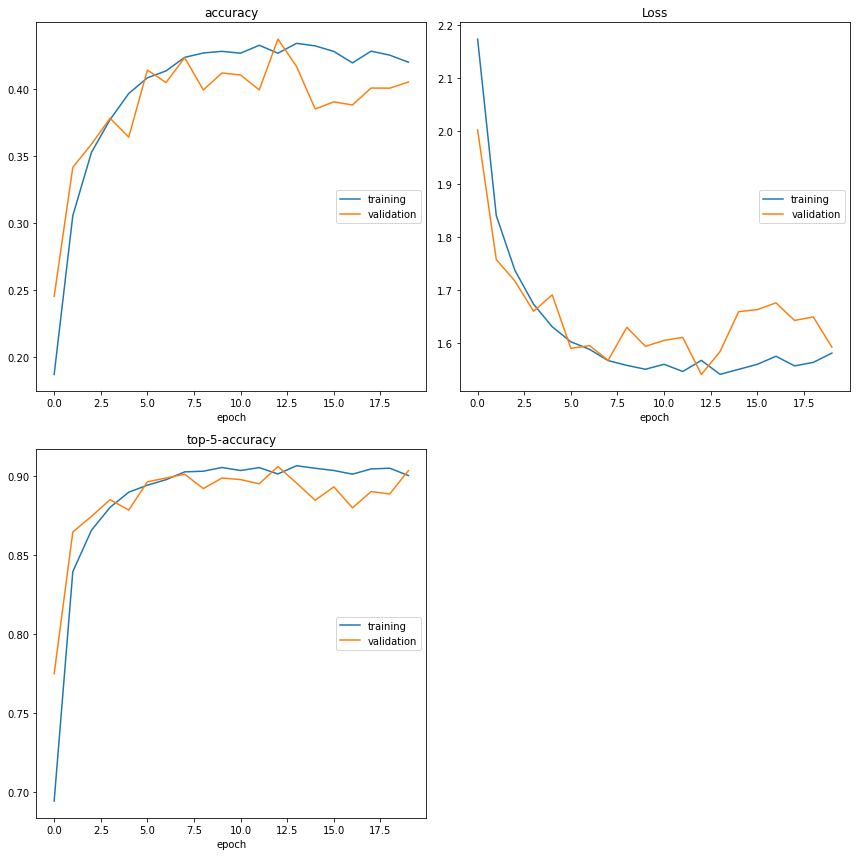

accuracy
	training         	 (min:    0.187, max:    0.434, cur:    0.420)
	validation       	 (min:    0.246, max:    0.437, cur:    0.405)
Loss
	training         	 (min:    1.541, max:    2.174, cur:    1.581)
	validation       	 (min:    1.541, max:    2.002, cur:    1.593)
top-5-accuracy
	training         	 (min:    0.694, max:    0.907, cur:    0.900)
	validation       	 (min:    0.775, max:    0.906, cur:    0.904)
157/157 [==============================] - 8s 53ms/step - loss: 1.5813 - accuracy: 0.4199 - top-5-accuracy: 0.9005 - val_loss: 1.5926 - val_accuracy: 0.4052 - val_top-5-accuracy: 0.9036


In [20]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=TrainingConfig.BATCH_SIZE,
        epochs=TrainingConfig.NUM_EPOCHS,
        validation_split=0.2,
        callbacks=[model_checkpoint_callback, PlotLossesKeras()],
    )